<a href="https://colab.research.google.com/github/konan108/ERC-Rebalancing/blob/main/erc_rebalancing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 🔄 Google Sheets → Colab → Google Sheets: ERC (Equal Risk Contribution)

Pipeline
1) Preise aus Google Sheets lesen (Format: Date, Ticker1, …).
2) Monats-Logreturns (5 Jahre Fenster, Month-End).
3) Kovarianz Σ bauen (symmetrisieren + Ridge), dann ERC (long-only).
4) Gewichte schreiben: SleeveWeight, TotalPortfolioWeight (=Sleeve*25%), RC_%.
5) Optional: RC%-Balken & lokaler CSV-Export.

In [25]:
# --- Installation (nur in Colab nötig) ---
%pip -q install gspread pandas numpy scipy

# --- Imports (sauber, zentral) ---
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from typing import Tuple
from datetime import datetime
import matplotlib.pyplot as plt

# Google Sheets API
from google.colab import auth
import gspread
from google.auth import default

# System & Zeit
import time
import zoneinfo

In [26]:
import time
import gspread

def safe_update(ws, range_name, values, retries=3, delay=2):
    """
    Robust update helper for Google Sheets to avoid API rate limit errors.
    Falls Rate-Limit oder temporäre Google-API-Fehler auftreten, wird automatisch erneut versucht.
    """
    for attempt in range(1, retries + 1):
        try:
            ws.update(values=values, range_name=range_name)
            return  # ✅ erfolgreich
        except gspread.exceptions.APIError as e:
            # Typischer Rate-Limit Fehler
            if attempt == retries:
                raise RuntimeError(f"Google Sheets Update endgültig fehlgeschlagen nach {retries} Versuchen.") from e
            wait = delay * attempt  # simples exponential backoff
            print(f"⚠️ Google API Limit – retry in {wait}s (Versuch {attempt}/{retries}) ...")
            time.sleep(wait)
        except Exception as e:
            # anderer Fehler → direkt weiterreichen
            raise RuntimeError("Unbekannter Fehler bei safe_update().") from e

In [27]:
# --- CONFIG ---------------------------------------------------------------

# Google Sheets Setup
SPREADSHEET_NAME = "ERC Rebalancing"        # Name der Google Sheet-Datei
PRICES_SHEET_NAME = "Prices_5Y"             # Tab mit Preis-Historie (Date + Ticker)
OUTPUT_SHEET_NAME = "Weights"               # Tab für ERC-Ergebnis (wird erstellt, falls nicht vorhanden)
SPREADSHEET_ID = None                       # Optional: ID als Alternative zum Namen (stabiler)

# Datenfenster
WINDOW_MONTHS = 60                          # Rolling-Window für Returns (z.B. 5 Jahre = 60 Monate)

# Portfolio-Logik
SLEEVE_SHARE = 0.25                         # Anteil des Satelliten-Portfolios am Gesamtportfolio

# Numerische Stabilität
RIDGE = 1e-10                               # Grund-Ridge für Kovarianz-Stabilisierung
COND_TARGET = 1e9                           # Ziel-Konditionszahl (adaptive Stabilisierung im Cov-Block)

# ERC Solver
N_STARTS = 32                               # Anzahl zufälliger Startpunkte (Robustheit)
SEED = 2025                                 # Zufalls-Seed für Reproduzierbarkeit

# Output Optionen
PLOT_RC = True                              # RC%-Barplot anzeigen
WRITE_CSV = True                            # Ergebnisse als CSV speichern

# --- CONFIG VALIDATION ----------------------------------------------------
def _validate_config():
    assert isinstance(WINDOW_MONTHS, int) and WINDOW_MONTHS >= 12, \
        f"WINDOW_MONTHS muss >= 12 sein (ist {WINDOW_MONTHS})."
    assert 0 < SLEEVE_SHARE <= 1, \
        f"SLEEVE_SHARE muss in (0,1] liegen (ist {SLEEVE_SHARE})."
    assert RIDGE > 0, \
        f"RIDGE muss > 0 sein (ist {RIDGE})."
    assert isinstance(N_STARTS, int) and N_STARTS >= 1, \
        f"N_STARTS muss int >= 1 sein (ist {N_STARTS})."

_validate_config()

# Übersicht
print(f"[CONFIG OK] WINDOW_MONTHS={WINDOW_MONTHS}, SLEEVE_SHARE={SLEEVE_SHARE}, "
      f"RIDGE={RIDGE}, N_STARTS={N_STARTS}, SEED={SEED}, COND_TARGET={COND_TARGET}")

[CONFIG OK] WINDOW_MONTHS=60, SLEEVE_SHARE=0.25, RIDGE=1e-10, N_STARTS=32, SEED=2025, COND_TARGET=1000000000.0


In [28]:
# --- AUTH & Access to Google Sheets ----------------------------------------
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Spreadsheet öffnen (ID bevorzugt, sonst Name)
if SPREADSHEET_ID:
    try:
        ss = gc.open_by_key(SPREADSHEET_ID)
        print(f"✅ Spreadsheet via ID geladen: {SPREADSHEET_ID}")
    except Exception as e:
        raise RuntimeError(f"❌ Konnte Spreadsheet mit ID nicht öffnen: {SPREADSHEET_ID}") from e
else:
    try:
        ss = gc.open(SPREADSHEET_NAME)
        print(f"✅ Spreadsheet via Name geladen: {SPREADSHEET_NAME}")
    except Exception as e:
        raise RuntimeError(f"❌ Spreadsheet '{SPREADSHEET_NAME}' nicht gefunden.") from e

# Prices-Worksheet öffnen
try:
    prices_ws = ss.worksheet(PRICES_SHEET_NAME)
    print(f"✅ Prices-Sheet gefunden: '{PRICES_SHEET_NAME}'")
except gspread.exceptions.WorksheetNotFound as e:
    raise RuntimeError(
        f"❌ Prices-Tab '{PRICES_SHEET_NAME}' nicht gefunden. "
        f"Bitte in Google Sheets anlegen."
    ) from e

# Output-Worksheet sicherstellen (idempotent)
try:
    weights_ws = ss.worksheet(OUTPUT_SHEET_NAME)
    print(f"✅ Output-Sheet gefunden: '{OUTPUT_SHEET_NAME}'")
except gspread.exceptions.WorksheetNotFound:
    print(f"ℹ️ Output-Sheet '{OUTPUT_SHEET_NAME}' nicht gefunden – wird erstellt ...")
    weights_ws = ss.add_worksheet(title=OUTPUT_SHEET_NAME, rows=1000, cols=26)
    print(f"✅ Output-Sheet erstellt.")

✅ Spreadsheet via Name geladen: ERC Rebalancing
✅ Prices-Sheet gefunden: 'Prices_5Y'
✅ Output-Sheet gefunden: 'Weights'


In [29]:
# --- Read Prices from Google Sheets ---------------------------------------
raw = prices_ws.get_all_values()
if not raw or len(raw) < 2:
    raise ValueError("Prices-Tab ist leer oder enthält keine gültigen Datenzeilen.")

# Header + Daten
hdr = raw[0]
rows = raw[1:]
df = pd.DataFrame(rows, columns=hdr)

# --- Datumsverarbeitung ----------------------------------------------------
date_col = df.columns[0]
df[date_col] = pd.to_datetime(df[date_col], errors="coerce", dayfirst=True)
df = df.dropna(subset=[date_col]).set_index(date_col).sort_index()
df.index.name = "Date"

# Doppelte Datumszeilen entfernen (z.B. Copy&Paste-Probleme)
df = df[~df.index.duplicated(keep="last")]

# Spaltennamen säubern
df.columns = df.columns.str.strip()

# --- Numerische Konvertierung ---------------------------------------------
# Nur Object-Spalten (außer Datum!) konvertieren
obj_cols = df.select_dtypes(include="object").columns
df[obj_cols] = df[obj_cols].replace({',': '.'}, regex=True)
df[obj_cols] = df[obj_cols].apply(pd.to_numeric, errors='coerce')

# --- Fehlende Werte behandeln ---------------------------------------------
# Spalten mit nur NaN entfernen
before_cols = df.shape[1]
df = df.dropna(how="all", axis=1)
removed_cols = before_cols - df.shape[1]
if removed_cols > 0:
    print(f"ℹ️ Entferne {removed_cols} leere Spalten (vollständig NaN).")

# Kleine Lücken zulassen (forward fill), dann alles was noch kaputt → raus
df = df.ffill().dropna(how="any")

# --- Guards ----------------------------------------------------------------
if df.shape[1] < 2:
    raise ValueError("Zu wenige Ticker gefunden – mindestens 2 benötigt.")
if df.empty:
    raise ValueError("Keine Preiszeitreihe nach Bereinigung übrig.")

print(f"✅ Preise geladen: {df.shape[1]} Ticker, {df.shape[0]} Monatsdaten")
print("   Zeitraum:", df.index.min().date(), "→", df.index.max().date())
df.tail()

✅ Preise geladen: 6 Ticker, 61 Monatsdaten
   Zeitraum: 2020-09-30 → 2025-09-30


,ABEC.DEX,ASML.AMS,IUI1.FRK,KEE.FRK,RMS.PAR,SU.PAR
Date,,,,,,
2025-05-30,150.3084,652.1704,487.45,365.3644,2428.0,221.35
2025-06-30,150.6844,675.8077,460.40,343.9310,2299.0,225.80
2025-07-31,169.1079,613.1000,422.50,322.3979,2151.0,228.25
2025-08-29,181.6965,636.6000,402.85,326.2859,2091.0,210.05
2025-09-30,211.9000,828.1000,379.75,315.0000,2083.0,237.60


In [30]:
# --- Returns (monthly log returns, last 5y) ---
def compute_returns(prices: pd.DataFrame) -> pd.DataFrame:
    """
    Erzeugt aus (täglichen/gemischten) Preisen eine Monatsreihe,
    indem je Kalendermonat die letzte beobachtete Zeile (letzter Handelstag) verwendet wird.
    Danach: Log-Returns.
    """
    if not isinstance(prices.index, pd.DatetimeIndex):
        raise TypeError("prices.index muss ein DatetimeIndex sein.")

    # Numerisch sauber halten
    px = prices.sort_index().astype("float64", copy=False)

    # Doppelte Datumszeilen entfernen
    px = px[~px.index.duplicated(keep="last")]

    # Pro Kalendermonat die letzte beobachtete Zeile (marktagnostisch)
    px = px.groupby(px.index.to_period("M")).tail(1)

    # Sicherheitsnetz
    if (px <= 0).any().any():
        bad_rows = int((px <= 0).any(axis=1).sum())
        raise ValueError(f"Preise enthalten nicht-positive Werte (Problem-Zeilen: {bad_rows}).")

    # Log-Returns
    rets = np.log(px).diff().dropna(how="any")

    # Optional (rein kosmetisch): Index als echtes Monatsende stempeln
    # rets.index = rets.index.to_period("M").to_timestamp("M")

    # Guard: non-finite
    if not np.isfinite(rets.to_numpy()).all():
        raise ValueError("Returns enthalten NaN/Inf/±∞ nach der Berechnung.")

    rets.index.name = "Date"
    return rets

# Monatsreturns berechnen
rets_all = compute_returns(df)

# Window schneiden (z.B. 60 Monate)
rets = rets_all.iloc[-WINDOW_MONTHS:].copy() if len(rets_all) > WINDOW_MONTHS else rets_all.copy()

# Sanity Checks (Returns)
assert rets.index.is_monotonic_increasing, "Index nicht chronologisch sortiert."
assert len(rets) >= 36, f"Mindestens 36 Monatsdaten notwendig, gefunden: {len(rets)}."
print("Returns shape (windowed):", rets.shape)
print("Zeitraum:", rets.index.min(), "→", rets.index.max())

Returns shape (windowed): (60, 6)
Zeitraum: 2020-10-30 00:00:00 → 2025-09-30 00:00:00


In [31]:
# --- Covariance (robust) ----------------------------------------------------
def build_cov(
    rets: pd.DataFrame,
    ridge: float = 1e-10,
    cond_target: float = 1e9,
    max_tries: int = 6,
    project_psd: bool = False,
) -> Tuple[np.ndarray, list[str]]:
    """
    Baut eine robuste Kovarianzmatrix Σ:
      - entfernt Zero-Var-Spalten,
      - symmetriert,
      - fügt adaptiv Ridge hinzu, bis cond(Σ) <= cond_target,
      - optional Projektion auf PSD (Eigenwerte < 0 -> 0).
    """
    # 0) Zero-Var-Spalten entfernen (verhindert Singularität)
    var = rets.var()
    keep = var[var > 0].index
    if len(keep) < rets.shape[1]:
        dropped = sorted(set(rets.columns) - set(keep))
        print(f"ℹ️ Entferne Zero-Var-Assets: {dropped} | verbleibend: {len(keep)}")
        rets = rets[keep]

    # 1) Sample-Cov + Symmetrie + Grund-Ridge
    Sigma_df = rets.cov()
    tickers = list(Sigma_df.columns)
    S = 0.5 * (Sigma_df.values + Sigma_df.values.T)
    S = np.asarray(S, dtype=np.float64, order="C")
    n = S.shape[0]

    # Guard
    if n == 0:
        raise ValueError("Kovarianz: keine Spalten übrig.")
    if not np.isfinite(S).all():
        raise ValueError("Kovarianzmatrix enthält NaN/Inf.")

    # Grund-Ridge
    S += np.eye(n) * ridge

    # 2) Adaptives „Jittern“ mit inkrementellem Delta
    total_jitter = ridge
    for k in range(max_tries + 1):
        cond = np.linalg.cond(S)
        if cond <= cond_target:
            break
        # neuen Ziel-Jitter wählen (zehnerlogarithmisch erhöhen, aber moderat starten)
        new_total = max(total_jitter * 10.0, 1e-12)
        delta = new_total - total_jitter
        S += np.eye(n) * delta
        S = 0.5 * (S + S.T)  # re-symmetrieren (Numerik)
        total_jitter = new_total
        if k == max_tries:
            print(f"⚠️ Σ bleibt schlecht konditioniert (cond≈{cond:.2e}) nach {max_tries} Jitter-Schritten.")

    # 3) Optional: Projektion auf PSD (clipping minimal negativer Eigenwerte)
    if project_psd:
        w, V = np.linalg.eigh(S)           # garantiert reelle Eigenwerte
        w = np.clip(w, 0.0, None)          # negative auf 0 setzen
        S = (V * w) @ V.T
        S = 0.5 * (S + S.T)                # numerisch symmetrisch machen

    return S, tickers

# Nutzung
S, tickers = build_cov(rets, ridge=RIDGE, cond_target=COND_TARGET, project_psd=False)
n = len(tickers)
print("Tickers:", tickers)
if n < 2:
    raise ValueError("Mindestens zwei Ticker benötigt.")
if not np.isfinite(S).all():
    raise ValueError("Kovarianzmatrix enthält NaN/Inf.")
print(f"cond(Σ) ≈ {np.linalg.cond(S):.2e}")

# (Optional, zur Sicherheit: Returns auf die finale Ticker-Reihenfolge alignen)
# rets = rets[tickers]

Tickers: ['ABEC.DEX', 'ASML.AMS', 'IUI1.FRK', 'KEE.FRK', 'RMS.PAR', 'SU.PAR']
cond(Σ) ≈ 1.72e+01


In [32]:
# --- ERC (pure long-only) ----------------------------------------------------
def total_variance(w: np.ndarray, S: np.ndarray) -> float:
    # nutzt vorab berechnetes Sw, wenn vorhanden (kleiner Speed-Up)
    Sw = S @ w
    return float(w @ Sw)

def risk_contributions(w: np.ndarray, S: np.ndarray, Sw: np.ndarray | None = None) -> np.ndarray:
    # RC_i = w_i * (Σ w)_i
    if Sw is None:
        Sw = S @ w
    return w * Sw

def erc_objective(w: np.ndarray, S: np.ndarray) -> float:
    # Zielfunktion: Sum_i (RC_i - TV/n)^2
    Sw = S @ w
    tv = float(w @ Sw)
    target = tv / len(w)
    rc = w * Sw
    diff = rc - target
    return float(diff @ diff)

def _project_feasible(x: np.ndarray, lo: np.ndarray, hi: np.ndarray) -> np.ndarray:
    # In Bounds clippen, dann Summe→1 sanft Richtung Bounds-Mittelpunkt
    x = np.clip(x, lo, hi)
    for _ in range(12):
        s = x.sum()
        if abs(s - 1.0) < 1e-12:
            break
        mid = (lo + hi) / 2.0
        x = np.clip(x + 0.5 * (mid - x) * (1.0 - s), lo, hi)
    return x

def erc_solve(
    S: np.ndarray,
    bounds: list[tuple[float, float]] | None = None,
    n_starts: int = N_STARTS,
    seed: int = SEED,
    ftol: float = 1e-16,
    maxiter: int = 20_000,
) -> tuple[np.ndarray, float]:
    n = S.shape[0]
    if bounds is None:
        bounds = [(0.0, 1.0)] * n  # long-only
    assert len(bounds) == n, "Länge von bounds passt nicht zu n."

    lo = np.array([b[0] for b in bounds], dtype=float)
    hi = np.array([b[1] for b in bounds], dtype=float)
    if not np.all(lo <= hi):
        raise ValueError("In bounds gibt es lo > hi.")

    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0},)
    rng = np.random.default_rng(seed)

    best_fun = np.inf
    best_x = None
    for _ in range(n_starts):
        x0 = rng.random(n); x0 /= x0.sum()
        x0 = _project_feasible(x0, lo, hi)
        res = minimize(
            erc_objective, x0, args=(S,),
            method="SLSQP",
            bounds=bounds, constraints=cons,
            options={'ftol': ftol, 'maxiter': maxiter, 'disp': False}
        )
        if res.success and res.fun < best_fun:
            best_fun = float(res.fun)
            best_x = res.x

    if best_x is None:
        raise RuntimeError("ERC-Optimierung: keine Konvergenz.")

    # finaler Cleanup: clippen & renormieren (idempotent)
    w = np.clip(best_x, lo, hi)
    w /= w.sum()
    return w, best_fun

def compute_rc_pct(w: np.ndarray, S: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    Sw = S @ w
    rc_abs = w * Sw
    rc_pct = rc_abs / rc_abs.sum()
    return rc_abs, rc_pct, Sw

def erc_check(w: np.ndarray, S: np.ndarray, idx) -> None:
    rc_abs, rc_pct, _ = compute_rc_pct(w, S)
    target = 1.0 / len(w)
    print("Anzahl Ticker:", len(w))
    print("Summe w:", float(w.sum()))
    print("min/max w:", float(w.min()), float(w.max()))
    print("RC% Ziel 1/n =", target)
    print("Max. Abweichung RC%:", float(np.abs(rc_pct - target).max()))
    print("Ø Abweichung RC%:", float(np.abs(rc_pct - target).mean()))
    print("Fensterlänge (Monate):", len(idx))
    print("Zeitspanne:", idx.min(), "→", idx.max())

# --- Solve (pure ERC, nur long-only bounds) ---------------------------------
bounds = [(0.0, 1.0) for _ in range(n)]
w_sleeve, obj = erc_solve(S, bounds=bounds)

# RC & Mapping
rc_abs, rc_pct, _ = compute_rc_pct(w_sleeve, S)
w_total = SLEEVE_SHARE * w_sleeve

# Qualitätscheck
target = 1 / len(w_sleeve)
max_dev = float(np.max(np.abs(rc_pct - target)))
erc_check(w_sleeve, S, rets.index)
assert np.isclose(w_sleeve.sum(), 1.0), "Sleeve-Weights ≠ 1."
assert np.isclose(w_total.sum(), SLEEVE_SHARE), "Total-Weights ≠ SLEEVE_SHARE."
assert max_dev < 1e-4, f"ERC nicht sauber konvergiert (Max RC%-Abw = {max_dev:.6g})"

# --- Output-DataFrame -------------------------------------------------------
out = pd.DataFrame({
    "Ticker": tickers,
    "SleeveWeight": w_sleeve,
    "TotalPortfolioWeight": w_total,
    "RC_%": rc_pct
}).sort_values("SleeveWeight", ascending=False).reset_index(drop=True)

# Sauber runden für Output
out = out.round({"SleeveWeight": 8, "TotalPortfolioWeight": 8, "RC_%": 8})


Anzahl Ticker: 6
Summe w: 1.0
min/max w: 0.12375349926669117 0.20545016620443748
RC% Ziel 1/n = 0.16666666666666666
Max. Abweichung RC%: 1.8096438542114512e-07
Ø Abweichung RC%: 6.911554688756223e-08
Fensterlänge (Monate): 60
Zeitspanne: 2020-10-30 00:00:00 → 2025-09-30 00:00:00


In [33]:
# --- Write back to Google Sheets (Output tab) ---
# Header + Werte zusammenbauen
values = [out.columns.tolist()] + out.astype(str).values.tolist()  # Strings verhindert Zellenformat-Probleme

# Sheet leeren und neu schreiben
weights_ws.clear()
safe_update(weights_ws, 'A1', values)

# Optional: Zeitstempel hinzufügen
berlin = zoneinfo.ZoneInfo("Europe/Berlin")
ts = datetime.now(berlin).strftime("%Y-%m-%d %H:%M:%S")

safe_update(weights_ws, 'G1', [[f"Updated: {ts}"]])

print(f"✅ Wrote {len(out)} rows to '{OUTPUT_SHEET_NAME}' in '{SPREADSHEET_NAME}' at {ts}.")


✅ Wrote 6 rows to 'Weights' in 'ERC Rebalancing' at 2025-10-20 10:47:50.


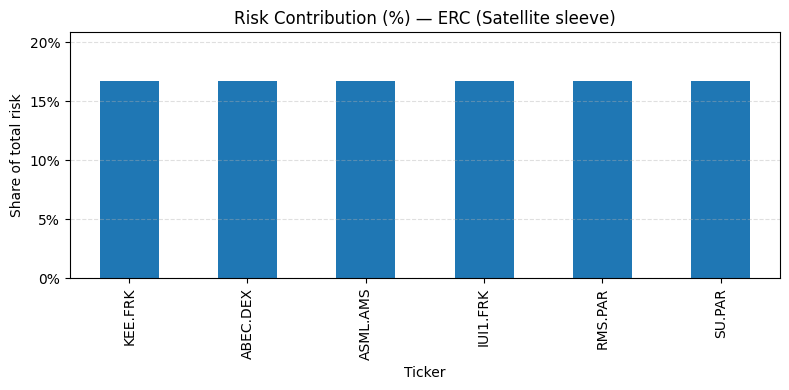

In [34]:
# --- Plot RC% (Risk Contribution) ---
fig, ax = plt.subplots(figsize=(8, 4))

# Balken nach Risiko sortieren (absteigend)
plot_data = out.set_index("Ticker")["RC_%"].sort_values(ascending=False)

# Plot
plot_data.plot.bar(ax=ax)

# Formatierung
ax.set_title("Risk Contribution (%) — ERC (Satellite sleeve)")
ax.set_ylabel("Share of total risk")
ax.set_xlabel("Ticker")
ax.set_ylim(0, plot_data.max() * 1.25)  # Luft nach oben
ax.grid(axis='y', linestyle='--', alpha=0.4)

# Y-Achse als Prozent
ax.yaxis.set_major_formatter(lambda y, _: f"{y:.0%}")

fig.tight_layout()
plt.show()
plt.close(fig)

In [35]:

# --- Save CSV locally (optional download) ---
csv_path = "/content/erc_weights_out.csv"
out.to_csv(csv_path, index=False)
print("Also saved locally at:", csv_path)


Also saved locally at: /content/erc_weights_out.csv
